In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/mikec/Documents/davidson/data/labeled_data.csv")

In [3]:
tweets=df.tweet

In [4]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

c:\users\mikec\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [7]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [8]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [9]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [10]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [11]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [12]:
feats = get_feature_array(tweets)

In [13]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [14]:
M.shape

(24783, 11172)

In [15]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [16]:
X = pd.DataFrame(M)
y = df['class'].astype(int)
X.columns = feature_names

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
y_train = y_train.to_frame(name='labels')
y_test = y_test.to_frame(name='labels')

In [18]:
def running(X_train, y_train, X_test, y_test, name, detail):
    X_train.to_csv('C:/Users/mikec/Documents/X_train.csv', index=None, header=True, encoding='utf-8')
    X_test.to_csv('C:/Users/mikec/Documents/X_test.csv', index=None, header=True, encoding='utf-8')
    y_train.to_csv('C:/Users/mikec/Documents/y_train.csv', index=None, header=True, encoding='utf-8')
    y_test.to_csv('C:/Users/mikec/Documents/y_test.csv', index=None, header=True, encoding='utf-8')
    import h2o
    h2o.init()
    from h2o.automl import H2OAutoML
    X_train = h2o.import_file('C:/Users/mikec/Documents/X_train.csv')
    y_train = h2o.import_file('C:/Users/mikec/Documents/y_train.csv')
    X_test = h2o.import_file('C:/Users/mikec/Documents/X_test.csv')
    y_test = h2o.import_file('C:/Users/mikec/Documents/y_test.csv')
    train = X_train.cbind(y_train)
    test = X_test.cbind(y_test)
    x = train.columns
    y = "labels"
    x.remove(y)
    train[y] = train[y].asfactor()
    test[y] = test[y].asfactor()
    aml = H2OAutoML(max_runtime_secs=3600) #max_models=10 or 20?, max_runtime_secs=3600
    aml.train(x=x, y=y, training_frame=train)
    lb = aml.leaderboard
    lb.head(rows=lb.nrows)
    aml.leader
    preds = aml.predict(test)
    print(preds)
    var = preds["predict"].cbind(test[y])
    print(var)
    y_test = h2o.as_list(test[y], use_pandas=True)
    y_pred = h2o.as_list(preds["predict"])
    report = classification_report(y_test, y_pred)
    print(report)
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.accuracy_score(y_test, y_pred))
    print(metrics.f1_score(y_test, y_pred, average='weighted'))
    confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
    matrix_proportions = np.zeros((3,3))
    for i in range(0,3):
        matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
    names=['Hate','Offensive','Neither']
    confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
    plt.figure(figsize=(5,5))
    seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
    plt.ylabel(r'True categories',fontsize=14)
    plt.xlabel(r'Predicted categories',fontsize=14)
    plt.tick_params(labelsize=12)
    plt.savefig('C:/Users/mikec/Documents/Results/{}.png'.format(name))
    f = open("C:/Users/mikec/Documents/Results/{}.txt".format(name), "a")
    print("{}".format(detail), file=f)
    print(report, file=f)
    print(metrics.confusion_matrix(y_test, y_pred), file=f)
    print(metrics.accuracy_score(y_test, y_pred), file=f)
    print(metrics.f1_score(y_test, y_pred, average='weighted'), file=f)
    f.close()


In [19]:
# Random Over-sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2)
X_ros, y_ros = ros.fit_sample(X_train, y_train)
X_ros = pd.DataFrame(X_ros)
X_ros.columns = feature_names
y_ros = pd.DataFrame(y_ros)
y_ros.columns = ['labels']

Using TensorFlow backend.
c:\users\mikec\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from c:\users\mikec\appdata\local\programs\python\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\mikec\AppData\Local\Temp\tmpx0rf86k2
  JVM stdout: C:\Users\mikec\AppData\Local\Temp\tmpx0rf86k2\h2o_mikec_started_from_python.out
  JVM stderr: C:\Users\mikec\AppData\Local\Temp\tmpx0rf86k2\h2o_mikec_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 1

H2O cluster uptime:,07 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 10 days
H2O cluster name:,H2O_from_python_mikec_tzt9ph
H2O cluster total nodes:,1
H2O cluster free memory:,1.752 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


predict,p0,p1,p2
1,0.000181305,0.99966,0.000158832
1,0.000215631,0.999636,0.00014827
1,0.00126706,0.9926,0.0061331
1,0.0057147,0.992471,0.00181479
1,0.000417807,0.999314,0.000268396
1,0.000564287,0.996088,0.003348
1,0.000212591,0.999575,0.000212859
1,0.000359411,0.999352,0.000288479
1,0.000195245,0.999632,0.000172482
1,0.000147112,0.999647,0.000206003


predict,labels
1,1
1,1
1,2
1,1
1,1
1,1
1,1
1,1
1,1
1,1


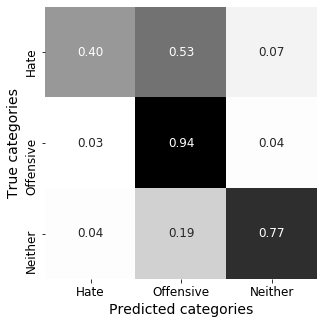

In [20]:
running(X_ros, y_ros, X_test, y_test, 'RandomOverSamplingMaxTime1', 'Sampling: Random Over-sampling and max runtime in 3600')
del X_ros
del y_ros


In [21]:
# SMOTE
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_smt, y_smt = smt.fit_sample(X_train, y_train)
X_smt = pd.DataFrame(X_smt)
X_smt.columns = feature_names
y_smt = pd.DataFrame(y_smt)
y_smt.columns = ['labels']

c:\users\mikec\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.37      0.43      0.40       164
           1       0.93      0.90      0.91      1905
           2       0.76      0.81      0.78       410

    accuracy                           0.86      2479
   macro avg       0.69      0.71      0.70      2479
weighted avg       0.86      0.86      0.86      2479

[[  70   76   18]
 [  98 1719   88]
 [  19

H2O cluster uptime:,1 hour 14 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_mikec_tzt9ph
H2O cluster total nodes:,1
H2O cluster free memory:,1.185 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


predict,p0,p1,p2
1,0.0157119,0.961487,0.0228015
1,0.0002002,0.99963,0.000169378
1,0.000453844,0.999157,0.000388784
1,0.145208,0.796635,0.0581573
1,0.000177103,0.999572,0.000250791
1,2.94017e-06,0.866832,0.133165
1,0.000603047,0.999311,8.56646e-05
1,0.0473764,0.934306,0.0183177
1,0.000235833,0.99904,0.000724065
1,0.000746754,0.998214,0.00103947


predict,labels
1,1
1,1
1,2
1,1
1,1
1,1
1,1
1,1
1,1
1,1


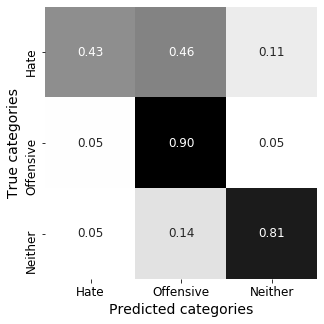

In [22]:
running(X_smt, y_smt, X_test, y_test, 'SMOTEMaxTime1', 'Sampling: SMOTE and max runtime in 3600')
del X_smt
del y_smt


In [23]:
# Random Under-sampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=2)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_rus = pd.DataFrame(X_rus)
X_rus.columns = feature_names
y_rus = pd.DataFrame(y_rus)
y_rus.columns = ['labels']

Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.29      0.72      0.41       164
           1       0.98      0.82      0.89      1905
           2       0.79      0.91      0.85       410

    accuracy                           0.83      2479
   macro avg       0.68      0.82      0.72      2479
weighted avg       0.90      0.83      0.85      2479

[[ 118   28   18]
 [ 266 1558   81]
 [  27

H2O cluster uptime:,2 hours 19 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_mikec_tzt9ph
H2O cluster total nodes:,1
H2O cluster free memory:,1.114 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


predict,p0,p1,p2
1,0.0766639,0.905956,0.0173801
1,0.109128,0.879538,0.0113347
2,0.155469,0.0782213,0.76631
0,0.758999,0.20811,0.0328913
1,0.296664,0.683808,0.0195274
1,0.114891,0.873222,0.0118879
1,0.1501,0.838058,0.0118413
1,0.147908,0.842438,0.00965433
1,0.0818861,0.909139,0.00897516
1,0.0780287,0.912925,0.0090467


predict,labels
1,1
1,1
2,2
0,1
1,1
1,1
1,1
1,1
1,1
1,1


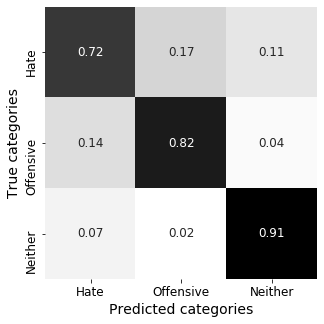

In [24]:
running(X_rus, y_rus, X_test, y_test, 'RandomUnderSamplingMaxTime1', 'Sampling: Random Under-sampling and max runtime in 3600')
del X_rus
del y_rus


In [25]:
# Near Miss
from imblearn.under_sampling import NearMiss
nmOne = NearMiss(version=1)
X_nmOne, y_nmOne = nmOne.fit_resample(X_train, y_train)
X_nmOne = pd.DataFrame(X_nmOne)
X_nmOne.columns = feature_names
y_nmOne = pd.DataFrame(y_nmOne)
y_nmOne.columns = ['labels']

c:\users\mikec\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.08      0.82      0.14       164
           1       0.94      0.19      0.31      1905
           2       0.56      0.45      0.50       410

    accuracy                           0.27      2479
   macro avg       0.53      0.49      0.32      2479
weighted avg       0.82      0.27      0.33      2479

[[ 135   19   10]
 [1411  359  135]
 [ 222

H2O cluster uptime:,3 hours 25 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_mikec_tzt9ph
H2O cluster total nodes:,1
H2O cluster free memory:,742 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


predict,p0,p1,p2
0,0.642423,0.324816,0.0327612
0,0.962277,0.0218539,0.0158687
0,0.991119,0.00120027,0.00768119
0,0.981608,0.00197256,0.0164194
0,0.994977,0.000647095,0.0043756
0,0.992188,0.0010454,0.00676617
0,0.99143,0.00262886,0.00594081
0,0.924812,0.038695,0.0364928
0,0.824372,0.0420158,0.133612
0,0.9598,0.0278147,0.0123856


predict,labels
0,1
0,1
0,2
0,1
0,1
0,1
0,1
0,1
0,1
0,1


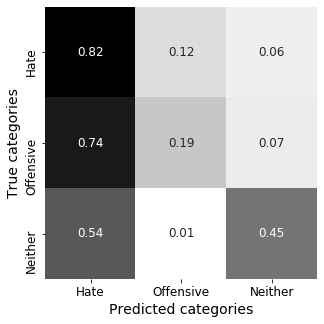

In [26]:
running(X_nmOne, y_nmOne, X_test, y_test, 'NearMiss1MaxTime1', 'Sampling: Near Miss version 1 and max runtime in 3600')
del X_nmOne
del y_nmOne


In [27]:
# Near Miss
from imblearn.under_sampling import NearMiss
nmTwo = NearMiss(version=2)
X_nmTwo, y_nmTwo = nmTwo.fit_resample(X_train, y_train)
X_nmTwo = pd.DataFrame(X_nmTwo)
X_nmTwo.columns = feature_names
y_nmTwo = pd.DataFrame(y_nmTwo)
y_nmTwo.columns = ['labels']

c:\users\mikec\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
running(X_nmTwo, y_nmTwo, X_test, y_test, 'NearMiss2MaxTime1', 'Sampling: Near Miss version 2 and max runtime in 3600')
del X_nmTwo
del y_nmTwo


Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


H2O cluster uptime:,4 hours 37 mins
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_mikec_tzt9ph
H2O cluster total nodes:,1
H2O cluster free memory:,438.0 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikec\\AppData\\Local\\Temp\\tmp0d3z4hqm.csv'

In [ ]:
# Near Miss
from imblearn.under_sampling import NearMiss
nmThree = NearMiss(version=3)
X_nmThree, y_nmThree = nm.fit_resample(X_train, y_train)
X_nmThree = pd.DataFrame(X_nmThree)
X_nmThree.columns = feature_names
y_nmThree = pd.DataFrame(y_nmThree)
y_nmThree.columns = ['labels']

In [ ]:
running(X_nmThree, y_nmThree, X_test, y_test, 'NearMiss3MaxTime1', 'Sampling: Near Miss version 3 and max runtime in 3600')
del X_nmThree
del y_nmThree


In [ ]:
# Instance Hardness Threshold
from imblearn.under_sampling import InstanceHardnessThreshold
iht = InstanceHardnessThreshold(random_state=2)
X_iht, y_iht = iht.fit_resample(X_train, y_train)
X_iht = pd.DataFrame(X_iht)
X_iht.columns = feature_names
y_iht = pd.DataFrame(y_iht)
y_iht.columns = ['labels']

In [ ]:
running(X_iht, y_iht, X_test, y_test, 'InstanceHardnessThresholdMaxTime1', 'Sampling: Instance Hardness Threshold and max runtime in 3600')
del X_iht
del y_iht


In [ ]:
'''Do not run after here'''











'''Do not run after here'''

In [ ]:
X = pd.DataFrame(M)
y = df['class'].astype(int)
X.columns = feature_names

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
y_train = y_train.to_frame(name='labels')
y_test = y_test.to_frame(name='labels')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [ ]:
y_train = y_train.to_frame(name='labels')
y_test = y_test.to_frame(name='labels')


In [ ]:
X_train.to_csv('C:/Users/mikec/Documents/X_train.csv', index=None, header=True, encoding='utf-8')
X_test.to_csv('C:/Users/mikec/Documents/X_test.csv', index=None, header=True, encoding='utf-8')
y_train.to_csv('C:/Users/mikec/Documents/y_train.csv', index=None, header=True, encoding='utf-8')
y_test.to_csv('C:/Users/mikec/Documents/y_test.csv', index=None, header=True, encoding='utf-8')

In [ ]:
import h2o
h2o.init()
from h2o.automl import H2OAutoML


In [ ]:
#X_train = h2o.H2OFrame(X_train)
#y_train = h2o.H2OFrame(y_train)
#X_test = h2o.H2OFrame(X_test)
#y_test = h2o.H2OFrame(y_test) 
X_train = h2o.import_file('C:/Users/mikec/Documents/X_train.csv')
y_train = h2o.import_file('C:/Users/mikec/Documents/y_train.csv')
X_test = h2o.import_file('C:/Users/mikec/Documents/X_test.csv')
y_test = h2o.import_file('C:/Users/mikec/Documents/y_test.csv')

In [ ]:
# preparing the train and test data sets
# now convert tweet vecs and labels to a pandas dataframe and back to h2o dataframe
train = X_train.cbind(y_train)
test = X_test.cbind(y_test)

In [ ]:
# more on data prep
x = train.columns         # x: A list/vector of predictor column names or indexes. 
                          # This argument only needs to be specified if the user wants to exclude columns from the 
                          # set of predictors. If all columns (other than the response) should be used in prediction, 
                          # then this does not need to be set.

y = "labels"              # This argument is the name (or index) of the response column
x.remove(y)

# need to set train and test
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [ ]:
# now the AUTO-ML piece comes in
aml = H2OAutoML(max_models=20) #max_models=10 or 20?, max_runtime_secs=3600
aml.train(x=x, y=y, training_frame=train)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
# The leader model is stored here
aml.leader

In [ ]:
preds = aml.predict(test)
print(preds)

In [ ]:
var = preds["predict"].cbind(test[y])
print(var)

In [ ]:
# convert to pandas dataframe
y_test = h2o.as_list(test[y], use_pandas=True)
y_pred = h2o.as_list(preds["predict"])
report = classification_report(y_test, y_pred)
print(report)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred, average='weighted'))

confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig('C:/Users/mikec/Documents/Results/H2OSamplingMax1.png')

f = open("C:/Users/mikec/Documents/Results/H2OSamplingMax1.txt", "a")
print("Sampling: used H2O built in, with max data size to original data size", file=f)
print(report, file=f)
print(metrics.confusion_matrix(y_test, y_pred), file=f)
print(metrics.accuracy_score(y_test, y_pred), file=f)
print(metrics.f1_score(y_test, y_pred, average='weighted'), file=f)
f.close()

